# Analysis
### Instacart Market Basket Analysis - Paige McKenzie

See my [blog post](https://p-mckenzie.github.io/content/python/2017/12/12/instacart-part-1/ "Instacart Part 2 - Modeling") on the subject.

#### Import packages and read in data, created by feature_engineering.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('x_train.csv', index_col=0)
df.head()

,user_id,order_id,product_id,target,avg_order_size,prev_ord_size,avg_days_between_orders,num_orders_placed,reordered_usr_avg,overall_avg_prod_disp,...,usr_avg_aisle_disp,usr_avg_dept_disp,usr_avg_prod_disp,prod_due_overall_perc,prod_due_user_perc,aisle_due_overall_perc,aisle_due_user_perc,dept_due_overall_perc,dept_due_user_perc,reorder_custom
0,1,1187899,196,1,5.9,9.0,19.56,11,0.695,66.272329,...,19.00,19.00,19.00,0.909,0.909,0.695,0.909,0.909,0.695,1
1,1,1187899,10258,1,5.9,9.0,19.56,11,0.695,56.355440,...,19.44,19.00,19.44,0.818,0.909,0.695,0.818,0.909,0.695,1
2,1,431534,10326,0,5.9,9.0,19.56,11,0.695,57.078752,...,87.50,87.50,97.00,0.182,0.182,0.695,0.182,0.182,0.695,0
3,1,2550362,12427,0,5.9,9.0,19.56,11,0.695,76.984336,...,19.00,19.00,19.00,0.909,0.909,0.695,0.909,0.909,0.695,1
4,1,1187899,13032,1,5.9,9.0,19.56,11,0.695,83.045575,...,58.33,58.33,58.33,0.273,0.273,0.695,0.273,0.273,0.695,1


In [3]:
df['target'].value_counts()

0    7645837
1     828824
Name: target, dtype: int64

# Split into train/test based on user_id to simulate Kaggle train/test environment

In [4]:
import random
mylist = list(df['user_id'].unique())

random.seed(9001)
train_users = [ mylist[i] for i in (random.sample(range(len(mylist)), int(.8*len(mylist)))) ]

train = df[df['user_id'].isin(train_users)]
test = df[~df['user_id'].isin(train_users)]

del df
del train_users

y_train = np.array(train['target'])
y_test = np.array(test['target'])

# note this ignores aisle/deparment
X_train = np.array(train[list(train.columns[4:])])
X_test = np.array(test[list(test.columns[4:])])

var_names = test.columns[4:]

del train
del test

# Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)

pred = log_model.predict(X_test)

print roc_auc_score(y_test, pred)

0.575449448601


In [7]:
confusion_matrix(y_test, pred)

array([[1515241,   16156],
       [ 139332,   26826]])

In [8]:
import pickle

pickle.dump(log_model, open('log.pickle', 'wb'))

# Neural Network

In [9]:
from sklearn.neural_network import MLPClassifier

In [10]:
hidden_layer_sizes = [(10,10),(20,20),(30,30),(40,40),(30,10),(10,30),(40,10),(10,40),(20,40),(40,20),(40,30),(30,40),(50,10),(10,50)]

for hidden_layer in hidden_layer_sizes:
    #define MLP
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer, activation='tanh',
                       solver='sgd', learning_rate='adaptive',
                      random_state=42, batch_size=500, learning_rate_init=.003,
                        momentum=.5, tol=.001, verbose=False,
                       early_stopping=True, validation_fraction=.2)

    #fit to training data
    mlp.fit(X_train, y_train)
    #predict on test data
    pred = mlp.predict(X_test)

    #find AUC on out-of-sample user_ids
    print('{} {} - AUC of {} at {}\n'.format(hidden_layer[0], hidden_layer[1], roc_auc_score(y_test, pred), datetime.datetime.now().strftime('%H:%M:%S')))

10 10 - AUC of 0.571545405359 at 14:16:30

20 20 - AUC of 0.564028186493 at 14:22:10

30 30 - AUC of 0.56824115195 at 14:29:42

40 40 - AUC of 0.573391535951 at 14:40:28

30 10 - AUC of 0.567336724571 at 14:45:47

10 30 - AUC of 0.571902902222 at 14:51:24

40 10 - AUC of 0.571801576075 at 14:57:57

10 40 - AUC of 0.579734696004 at 15:04:19

20 40 - AUC of 0.571531376062 at 15:12:27

40 20 - AUC of 0.575220450564 at 15:20:25

40 30 - AUC of 0.578366014653 at 15:28:40

30 40 - AUC of 0.577656682285 at 15:37:19

50 10 - AUC of 0.574887862237 at 15:44:24

10 50 - AUC of 0.574112481921 at 15:50:41



In [11]:
#re-fit best model
mlp = MLPClassifier(hidden_layer_sizes=(10,40), activation='tanh',
                       solver='sgd', learning_rate='adaptive',
                      random_state=42, batch_size=500, learning_rate_init=.003,
                        momentum=.5, tol=.001, verbose=False,
                       early_stopping=True, validation_fraction=.2)

#fit to training data
mlp.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size=500, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(10, 40), learning_rate='adaptive',
       learning_rate_init=0.003, max_iter=200, momentum=0.5,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.001, validation_fraction=0.2, verbose=False,
       warm_start=False)

In [12]:
pred = mlp.predict(X_test)

print roc_auc_score(y_test, pred)

0.579734696004


In [13]:
confusion_matrix(y_test, pred)

array([[1513389,   18008],
       [ 137707,   28451]])

In [14]:
import pickle

pickle.dump(mlp, open('mlp.pickle', 'wb'))

# XGBoost

In [15]:
import xgboost

In [16]:
#re-fit model with best parameters

gbm = xgboost.XGBClassifier(objective='binary:logistic',
                            max_depth=10,
                            learning_rate=.2,
                            n_estimators=140,
                            subsample=.8,
                            colsample_bytree=.8)

gbm.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='auc',
                early_stopping_rounds=2)

XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=140, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [18]:
pred = gbm.predict(X_test)

print roc_auc_score(y_test, pred)

0.588788293785


In [19]:
confusion_matrix(y_test, pred)

array([[1513819,   17578],
       [ 134745,   31413]])

In [20]:
import pickle

pickle.dump(gbm, open('xgb.pickle', 'wb'))

# LightGBM

In [21]:
import lightgbm

In [22]:
%%time
leaves = [20,40,80]
n_estimators = [40,140,240,340]
learning_rates = [.1,.2]

for learning_rate in learning_rates:
    for n_tree in n_estimators:
        for leaf in leaves:
            gbm = lightgbm.LGBMClassifier(objective='binary:logistic',
                            num_leaves=leaf,
                            learning_rate=learning_rate,
                            n_estimators=n_tree,
                            feature_fraction=.8)

            gbm.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='auc',
                early_stopping_rounds=2, verbose=False)

            print '{}\t{}\t{}\tAUC {} at {}'.format(learning_rate, n_tree, leaf, roc_auc_score(y_test, gbm.predict(X_test, num_iteration=gbm.best_iteration_)), datetime.datetime.now().strftime('%H:%M:%S'))

0.1	40	20	AUC 0.578251924066 at 20:56:32
0.1	40	40	AUC 0.581280609869 at 20:57:46
0.1	40	80	AUC 0.583088438328 at 20:59:11
0.1	140	20	AUC 0.587328261938 at 21:02:19
0.1	140	40	AUC 0.588155576665 at 21:05:52
0.1	140	80	AUC 0.589233750318 at 21:09:47
0.1	240	20	AUC 0.587838371038 at 21:13:56
0.1	240	40	AUC 0.588321732852 at 21:18:07
0.1	240	80	AUC 0.589233750318 at 21:22:06
0.1	340	20	AUC 0.587838371038 at 21:26:17
0.1	340	40	AUC 0.588321732852 at 21:30:29
0.1	340	80	AUC 0.589233750318 at 21:34:27
0.2	40	20	AUC 0.586425691269 at 21:35:30
0.2	40	40	AUC 0.587534467847 at 21:36:44
0.2	40	80	AUC 0.588025843342 at 21:38:07
0.2	140	20	AUC 0.58806239631 at 21:40:28
0.2	140	40	AUC 0.589345595929 at 21:42:43
0.2	140	80	AUC 0.588975871948 at 21:44:31
0.2	240	20	AUC 0.58806239631 at 21:46:56
0.2	240	40	AUC 0.589345595929 at 21:49:16
0.2	240	80	AUC 0.588975871948 at 21:51:07
0.2	340	20	AUC 0.58806239631 at 21:53:31
0.2	340	40	AUC 0.589345595929 at 21:55:46
0.2	340	80	AUC 0.588975871948 at 21:57:42
W

In [23]:
#re-fit model with best parameters

gbm = lightgbm.LGBMClassifier(objective='binary:logistic',
                            num_leaves=40,
                            learning_rate=.2,
                            n_estimators=140,
                            feature_fraction=.8)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        early_stopping_rounds=2, verbose=False)

In [24]:
pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print roc_auc_score(y_test, pred)

0.589743339731


In [25]:
confusion_matrix(y_test, pred)

array([[1513334,   18063],
       [ 134375,   31783]])

In [26]:
import pickle

pickle.dump(gbm, open('lgb.pickle', 'wb'))

# Model Comparisons

In [27]:
import pickle

log = pickle.load(open('log.pickle', 'rb'))
mlp = pickle.load(open('mlp.pickle', 'rb'))
xgb = pickle.load(open('xgb.pickle', 'rb'))
lgb = pickle.load(open('lgb.pickle', 'rb'))

In [28]:
log_pred = log.predict(X_test)
mlp_pred = mlp.predict(X_test)
xgb_pred = xgb.predict(X_test)
lgb_pred = lgb.predict(X_test)

In [29]:
from sklearn.metrics import roc_curve

x_log, y_log, t_log = roc_curve(y_test, log_pred, pos_label=1)
x_mlp, y_mlp, t_mlp = roc_curve(y_test, mlp_pred, pos_label=1)
x_xgb, y_xgb, t_xgb = roc_curve(y_test, xgb_pred, pos_label=1)
x_lgb, y_lgb, t_lgb = roc_curve(y_test, lgb_pred, pos_label=1)

print [list(x_log), list(x_mlp), list(x_xgb), list(x_lgb)]
print [list(y_log), list(y_mlp), list(y_xgb), list(y_lgb)]

[[0.0, 0.010549844357798795, 1.0], [0.0, 0.011759197647638072, 1.0], [0.0, 0.011478408276887052, 1.0], [0.0, 0.011795112567152736, 1.0]]
[[0.0, 0.1614487415592388, 1.0], [0.0, 0.17122858965562898, 1.0], [0.0, 0.18905499584732605, 1.0], [0.0, 0.19128179202927334, 1.0]]


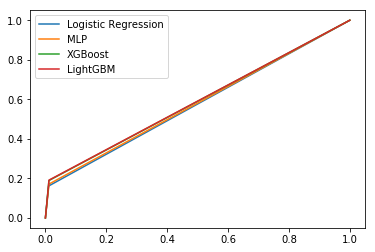

In [30]:
names  = ['Logistic Regression', 'MLP', 'XGBoost', 'LightGBM']

plt.plot(x_log, y_log)
plt.plot(x_mlp, y_mlp)
plt.plot(x_xgb, y_xgb)
plt.plot(x_lgb, y_lgb)

plt.legend(names)
plt.show()

# Make Predictions

In [31]:
df = pd.read_csv('x_test.csv', index_col=0)
df.head()

,user_id,order_id,product_id,target,avg_order_size,prev_ord_size,avg_days_between_orders,num_orders_placed,reordered_usr_avg,overall_avg_prod_disp,...,usr_avg_aisle_disp,usr_avg_dept_disp,usr_avg_prod_disp,prod_due_overall_perc,prod_due_user_perc,aisle_due_overall_perc,aisle_due_user_perc,dept_due_overall_perc,dept_due_user_perc,reorder_custom
120,3,2774568,248,2,7.33,6.0,12.09,13,0.625,109.905904,...,45.0,20.57,135.00,0.231,0.538,0.625,0.231,0.538,0.625,0
121,3,2774568,1005,2,7.33,6.0,12.09,13,0.625,108.401544,...,37.0,45.00,37.00,0.077,0.231,0.625,0.077,0.231,0.625,0
122,3,2774568,1819,2,7.33,6.0,12.09,13,0.625,87.987620,...,23.5,23.50,31.33,0.308,0.308,0.625,0.308,0.308,0.625,0
123,3,2774568,7503,2,7.33,6.0,12.09,13,0.625,96.378691,...,45.0,20.57,114.00,0.231,0.538,0.625,0.231,0.538,0.625,0
124,3,2774568,8021,2,7.33,6.0,12.09,13,0.625,83.698469,...,135.0,135.00,135.00,0.077,0.077,0.625,0.077,0.077,0.625,0


In [32]:
X = df.as_matrix(columns=df.columns[4:])

In [33]:
import pickle

log = pickle.load(open('log.pickle', 'rb'))
mlp = pickle.load(open('mlp.pickle', 'rb'))
xgb = pickle.load(open('xgb.pickle', 'rb'))
lgb = pickle.load(open('lgb.pickle', 'rb'))

In [34]:
df = df[['order_id', 'product_id', 'avg_order_size', 'prev_ord_size']]

df['log_pred'] = log.predict(X)
df['log_prob'] = log.predict_proba(X)[:,0]

df['mlp_pred'] = mlp.predict(X)
df['mlp_prob'] = mlp.predict_proba(X)[:,0]

df['xgb_pred'] = xgb.predict(X)
df['xgb_prob'] = xgb.predict_proba(X)[:,0]

df['lgb_pred'] = lgb.predict(X)
df['lgb_prob'] = lgb.predict_proba(X)[:,0]

df.head()

,order_id,product_id,avg_order_size,prev_ord_size,log_pred,log_prob,mlp_pred,mlp_prob,xgb_pred,xgb_prob,lgb_pred,lgb_prob
120,2774568,248,7.33,6.0,0,0.972031,0,0.984377,0,0.970881,0,0.979271
121,2774568,1005,7.33,6.0,0,0.942469,0,0.948694,0,0.953822,0,0.950803
122,2774568,1819,7.33,6.0,0,0.867264,0,0.903163,0,0.878013,0,0.902975
123,2774568,7503,7.33,6.0,0,0.968177,0,0.976053,0,0.971565,0,0.966158
124,2774568,8021,7.33,6.0,0,0.954667,0,0.980414,0,0.965675,0,0.974175


In [35]:
print df['log_pred'].value_counts()
print df['mlp_pred'].value_counts()
print df['xgb_pred'].value_counts()
print df['lgb_pred'].value_counts()

0    4710200
1     123092
Name: log_pred, dtype: int64
0    4698373
1     134919
Name: mlp_pred, dtype: int64
0    4692413
1     140879
Name: xgb_pred, dtype: int64
0    4690551
1     142741
Name: lgb_pred, dtype: int64


**Note that the positive class in the train set was about 10% of the rows, and all models are dramatically under-predicting!**

In [36]:
print df['lgb_prob'].mean(), df['lgb_prob'].min(), df['lgb_prob'].max()

0.900562425855 0.020022033575 0.999231759337


**The mean probility is 90%!**

In [37]:
df[df['order_id']==2774568].sort_values('lgb_prob', ascending=False)

,order_id,product_id,avg_order_size,prev_ord_size,log_pred,log_prob,mlp_pred,mlp_prob,xgb_pred,xgb_prob,lgb_pred,lgb_prob
142,2774568,38596,7.33,6.0,0,0.973590,0,0.984498,0,0.984444,0,0.990943
128,2774568,15143,7.33,6.0,0,0.969365,0,0.975996,0,0.987458,0,0.987098
120,2774568,248,7.33,6.0,0,0.972031,0,0.984377,0,0.970881,0,0.979271
124,2774568,8021,7.33,6.0,0,0.954667,0,0.980414,0,0.965675,0,0.974175
145,2774568,40604,7.33,6.0,0,0.959093,0,0.982754,0,0.971955,0,0.971412
144,2774568,39922,7.33,6.0,0,0.960637,0,0.969783,0,0.971800,0,0.968928
123,2774568,7503,7.33,6.0,0,0.968177,0,0.976053,0,0.971565,0,0.966158
126,2774568,12845,7.33,6.0,0,0.958715,0,0.956073,0,0.968334,0,0.964373
152,2774568,49683,7.33,6.0,0,0.936041,0,0.979806,0,0.955339,0,0.962459
132,2774568,18370,7.33,6.0,0,0.944245,0,0.951660,0,0.959527,0,0.957008


# Average probability is too high!
There's no separation to differentiate user-product pairs.
See Final Analysis notebook for a different approach, and check out my [blog post](https://p-mckenzie.github.io/2017/12/12/instacart-part-2/ "Instacart Part 2 - Modeling") on the subject.